# Unupervised Learning
---

This section will cover steps from importing the data, cleaning/preprocessing, implementing the algorithms required, tuning with hyperparameters, and modeling the accuracy.

##### Import Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import time
import sklearn.metrics
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler

##### Load data
Heart disease and smoke detection datasets

In [2]:
heart_df = pd.read_csv("datasets/heart_attack.csv")
smoke_df = pd.read_csv("datasets/smoke_detection_iot.csv")

##### Split Data: Heart Disease
Create train and test subsets to train the data with the 5 different algorithms for each dataset

In [3]:
X_heart = heart_df.drop(columns="output") 
y_heart = heart_df["output"]

In [4]:
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X_heart, # predictive variables
    y_heart, # target
    test_size=0.33, # portion of dataset to allocate to test set
    random_state=10, # we are setting the seed here
)

X_train_heart.shape, X_test_heart.shape

((203, 13), (100, 13))

##### Split Data: Smoke Detection
Create train and test subsets to train the data with the 5 different algorithms for each dataset

In [5]:
X_smoke, y_smoke = smoke_df.drop(columns="Fire Alarm"), smoke_df["Fire Alarm"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_smoke, # predictive variables
    y_smoke, # target
    test_size=0.1, # portion of dataset to allocate to test set
    random_state=10, # we are setting the seed here
)

X_train.shape, X_test.shape

((56367, 15), (6263, 15))

## Step 1: Run Clustering Algorithms
---

### K-Means Clustering
- [How to Choose a cluster](https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92) <br>
- [Silhouette and Elbow](https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/?)

##### Train K-Means

In [31]:
def chooseBestKforKMeans(scaled_data, k_range, alpha_k=0.02):
    
    ans = []
    train_times = []

    for k in k_range:
        
        inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
        start_time = time.time() #start time for wall clock
        kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data) #train algorithm
        end_time = time.time() #end time for wall clock
        total_time = end_time-start_time
        train_times.append(total_time)
        scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
        ans.append((k, scaled_inertia))
        
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results, train_times

##### Choose Cluster
Returns dataframe of best cluster

In [32]:
def get_best_k(results):
    min_val = float(results.min())
    return results[results['Scaled Inertia']==min_val]

#### Adjusted Interia

In [33]:
def adusted_inertia(results):
    plt.figure(figsize=(7,4))
    plt.plot(results,'-o')
    plt.title('Adjusted Inertia for each K')
    plt.xlabel('K')
    plt.ylabel('Adjusted Inertia')
    plt.xticks(range(2,20,1))
    plt.show()
    return plt

#### Silhouette Analysis
- [What is Silhouette Analysis/Coefficient?](https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c)

##### K-Means Clustering SA Plot

In [34]:
def silhouette_analysis_kmeans(n_clusters, X):
    
    S=[]
    
    for k in n_clusters:
    
        # Set the model and its parameters
        model = KMeans(n_clusters=k, random_state=10)

        # Fit the model
        labels = model.fit_predict(X)
        
        # Calculate Silhoutte Score and append to a list
        S.append(silhouette_score(X, labels, metric='euclidean'))
    
    # Plot the resulting Silhouette scores on a graph
    plt.figure()
    plt.plot(n_clusters, S, '-o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Identify the number of clusters using Silhouette Score')
    plt.show()
    
    return plt

##### Expectation Maximization SA Plot

In [35]:
def silhouette_analysis_em(n_clusters, X):
    
    S=[]
    
    for k in n_clusters:
    
        # Set the model and its parameters
        model = GaussianMixture(n_components=k, n_init=20, random_state=10, reg_covar=1e-5)

        # Fit the model
        labels = model.fit_predict(X)
        
        # Calculate Silhoutte Score and append to a list
        S.append(silhouette_score(X, labels, metric='euclidean'))
    
    # Plot the resulting Silhouette scores on a graph
    plt.figure()
    plt.plot(n_clusters, S, '-o')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Identify the number of clusters using Silhouette Score')
    plt.show()
    
    return plt

#### Heart Disease Portion

##### Scale Data

In [36]:
# choose features: WILL NEED TO CHANGE TO X_heart???
data_for_clustering = heart_df
data_for_clustering.fillna(0,inplace=True)

# create data matrix
data_matrix = np.matrix(data_for_clustering).astype(float)

# scale the data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
scaled_data = mms.fit_transform(data_matrix)

k_range=range(2,20)

##### K-Means Clustering

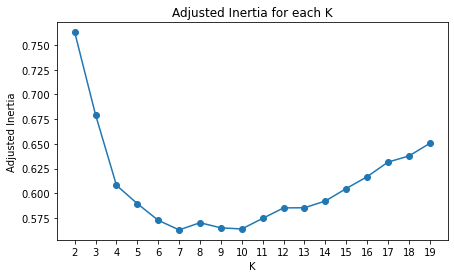

In [37]:
best_k, results, train_times = chooseBestKforKMeans(scaled_data, k_range)
adusted_inertia(results)
plt.show()

# figure out where to include the time for wall-clock HERE:
# plt.plot(train_times, '-o')
# plt.title('Wall Clock Time')
# plt.xlabel('Training Size')
# plt.ylabel('Training Time')
# plt.xticks(range(2,20,1))
# plt.show()

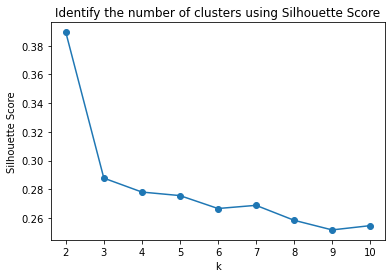

In [38]:
silhouette_analysis_kmeans(range(2,11), X_heart)
plt.show()

##### Expectation Maximization

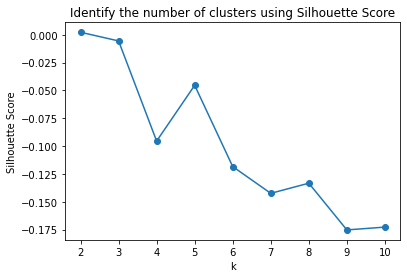

In [39]:
silhouette_analysis_em(range(2,11), X_heart)
plt.show()

#### Smoke Detection Portion

##### Scale Data

In [40]:
# choose features
data_for_clustering = smoke_df
data_for_clustering.fillna(0,inplace=True)

# create data matrix
data_matrix = np.matrix(data_for_clustering).astype(float)

# scale the data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
scaled_data = mms.fit_transform(data_matrix)

k_range=range(2,20)

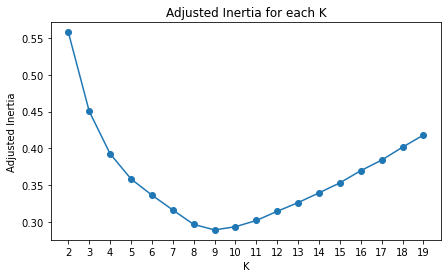

In [41]:
best_k, results, train_times = chooseBestKforKMeans(scaled_data, k_range)
adusted_inertia(results)
plt.show()

# figure out where to include the time for wall-clock HERE:
# train_times = []
# start_time = time.time()
# end_time = time.time()
# total_time = end_time-start_time
# train_times.append(end_time - start_time)

In [42]:
get_best_k(results)

,Scaled Inertia
k,
9,0.2888


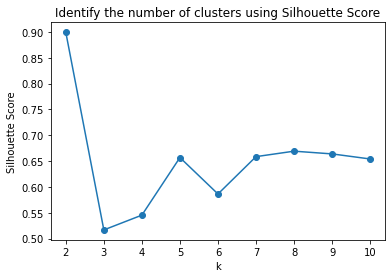

In [45]:
silhouette_analysis_kmeans(range(2, 11), X_smoke)
plt.show()

##### Expectation Maximization

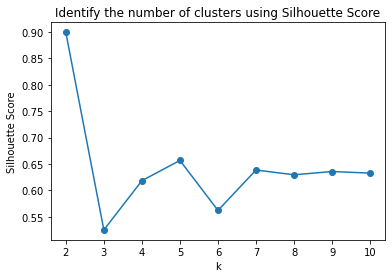

In [46]:
silhouette_analysis_em(range(2, 11), X_smoke)
plt.show()

### Step 2: Dimensionality Reduction

##### Heart

##### PCA
- [What is PCA?](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)<br>
- [PCA in python](https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/#:~:text=Short%20answer,-Don't%20do&text=Don't%20choose%20the%20number,and%201%20before%20using%20PCA!) <br>
- [Covariance vs Correlation](https://www.wallstreetmojo.com/correlation-vs-covariance/)
- Eigenvectors of the covariance matrix make up the components that are picked

In [47]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict

def run_PCA(X, title):
    """
    :param X: is the scaled data after using MinMaxScaler
    :param y: is the test data for given dataset
    :param title: sets the title of the PCA graph
    """
    
    plt.rcParams["figure.figsize"] = (12,6)
    pca = PCA(n_components=14, random_state=10).fit(X)
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    plt.ylim(0, 1.1)
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(10, 0.90, '95% cut-off threshold', color = 'red', fontsize=11)

    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-', marker='o', linestyle='--')
    ax1.set_xlabel('Number of Principal Components')
    
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio (%)', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'g-', marker='o', linestyle='--')
    ax2.set_ylabel('Eigenvalues', color='g')
    ax2.tick_params('y', colors='g')
    plt.grid(False)
    ax1.grid(axis='x')
    plt.title("PCA Number of Components: Explained Variance and Eigenvalues for "+ title)
    fig.tight_layout()
    plt.show()

/var/folders/0z/b69fyzzx0s57g_69wvxdmk1m0000gn/T/ipykernel_29817/926515692.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-', marker='o', linestyle='--')
/var/folders/0z/b69fyzzx0s57g_69wvxdmk1m0000gn/T/ipykernel_29817/926515692.py:32: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'g-', marker='o', linestyle='--')


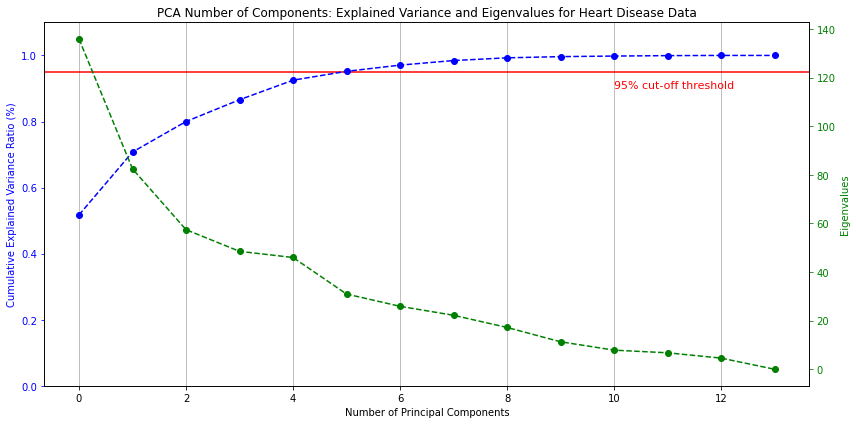

In [48]:
run_PCA(scaled_data, "Heart Disease Data")

##### ICA

In [49]:
def run_ICA(X, title):
    dims = list(np.arange(2,(X.shape[1]-1),3))
    dims.append(X.shape[1])
    ica = ICA(random_state=10)
    kurt = []

    for dim in dims:
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


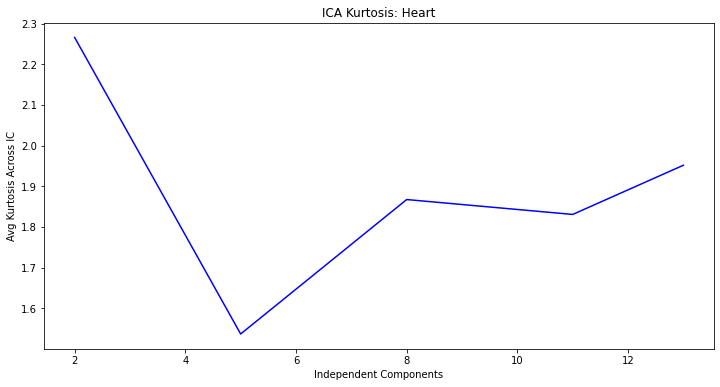

In [50]:
run_ICA(X_heart, "Heart")

##### Randomized Projections
Sparse Random Projection method <br>
[Choosing an RP algorithm](https://medium.com/data-science-in-your-pocket/random-projection-for-dimension-reduction-27d2ec7d40cd)

Shape of transformed data: (100, 13)


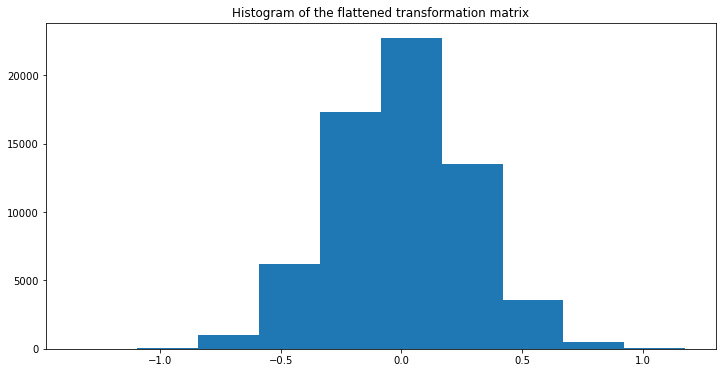

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-17.332043,-10.018864,10.095356,12.740871,-3.621858,1.435229,8.677459,2.229198,5.150060,-14.778093,8.108695,-0.572835,-14.696477
1,-1.214274,-6.713947,-10.026963,15.143148,1.385443,-12.023904,6.037941,-8.967004,3.647978,-21.335723,9.732862,0.299266,-15.196394
2,-5.300827,-10.199131,-4.786038,14.169263,3.078262,-12.826562,6.066373,-8.887626,5.957349,-13.883918,-1.038342,4.839731,-7.851581
3,-12.579714,-8.770980,-1.050312,17.962352,7.322978,-22.386658,-11.665662,4.438202,9.578866,-19.367364,10.445118,13.798773,-21.389786
4,-0.013586,-16.943772,7.235381,11.738645,-6.254382,-15.745371,-10.619764,-4.865944,11.419542,-20.124100,2.828259,10.243093,-4.535998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-5.607331,-21.948814,6.461882,7.444693,0.013130,-5.198897,-8.461769,1.001681,7.118340,-13.157957,-1.406071,6.609123,-17.820003
96,4.618977,-6.312395,6.222677,12.000344,0.206963,-6.278012,-14.088454,16.645968,12.995167,-18.682927,1.929929,12.025557,-21.051350
97,-1.711549,-8.374015,3.653722,7.421742,1.608350,-7.191410,-1.725227,0.757061,10.290587,-9.217666,5.589429,5.530239,-19.298725
98,-16.383942,-23.988256,0.294151,9.359212,-0.402552,-19.896653,-11.405773,10.207069,9.254246,-10.851344,3.890163,-1.495865,-18.911673


In [51]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.random_projection import GaussianRandomProjection
# import numpy as np
# from matplotlib import pyplot as plt
# import sklearn.datasets as dt
# from sklearn.metrics.pairwise import euclidean_distances
from sklearn import random_projection

def run_RP(X, comp, hist=True):
    X_rand = np.random.RandomState(0).rand(100, 5000)
    proj_gauss = GaussianRandomProjection(random_state=0, n_components=comp)
    X_transformed = proj_gauss.fit_transform(X_rand)
    df = pd.DataFrame(data = X_transformed)

    # Print the size of the transformed data
    print('Shape of transformed data: ' + str(X_transformed.shape))
    
    
    if hist:
        plt.hist(proj_gauss.components_.flatten())
        plt.title('Histogram of the flattened transformation matrix')
        plt.show()
    
    return df
    
run_RP(X_heart, 13)

##### Truncated Singular Value Decomposition (SVD)

In [93]:
from sklearn.datasets import load_iris
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import statistics

def run_SVD(X_data, y_data):
    # defining dataset
    X, y = X_data, y_data
     # get a list of models
    def get_models():
        models = dict()
        for i in range(1,12):
            steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression(max_iter=1000))]
            models[str(i)] = Pipeline(steps=steps)
        return models
    # evaluate a give model using cross-validation
    def evaluate_model(model, X, y):
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        return scores
    # get the models to evaluate
    models = get_models()
     # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, statistics.mean(scores), statistics.stdev(scores)))
    # plot model performance for comparison
    plt.boxplot(results, labels=names, showmeans=True)
    plt.xticks(rotation=45)
    plt.title("Truncated SVD")
    plt.xlabel("n components")
    plt.ylabel("Mean classification accuracy")
    plt.show()
    
    return plt

>1 0.539 (0.019)
>2 0.636 (0.065)
>3 0.702 (0.063)
>4 0.699 (0.066)
>5 0.808 (0.071)
>6 0.821 (0.067)
>7 0.817 (0.067)
>8 0.830 (0.067)
>9 0.846 (0.070)
>10 0.843 (0.076)
>11 0.830 (0.074)


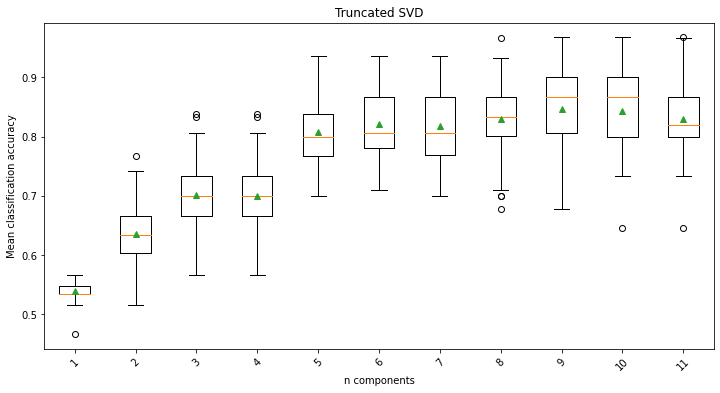

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [94]:
run_SVD(X_heart, y_heart)

##### Smoke

##### PCA

/var/folders/0z/b69fyzzx0s57g_69wvxdmk1m0000gn/T/ipykernel_29817/926515692.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-', marker='o', linestyle='--')
/var/folders/0z/b69fyzzx0s57g_69wvxdmk1m0000gn/T/ipykernel_29817/926515692.py:32: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'g-', marker='o', linestyle='--')


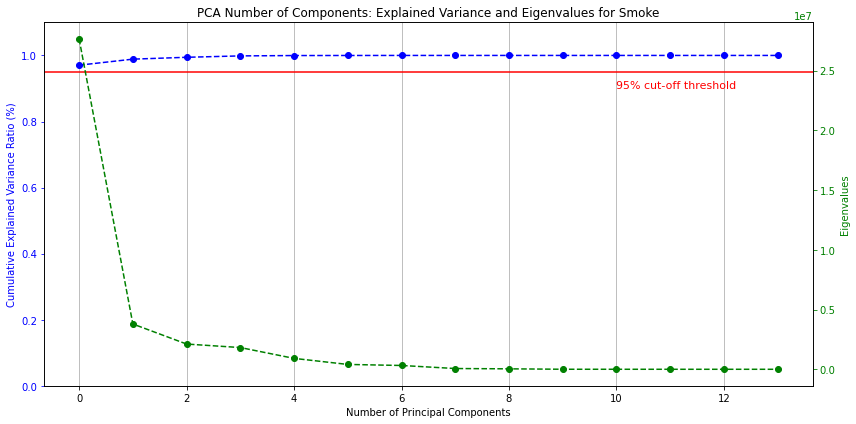

In [53]:
run_PCA(X_smoke, "Smoke")

##### ICA

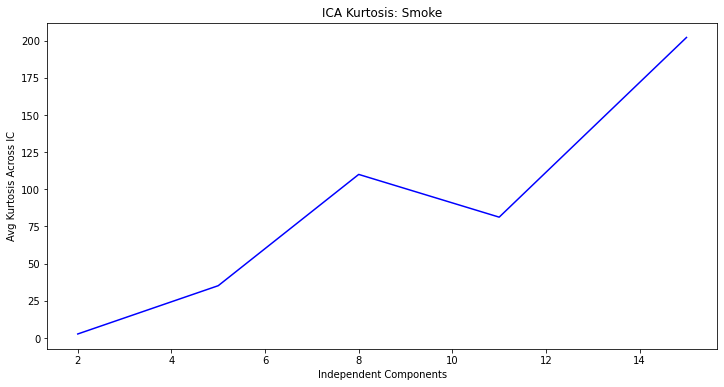

In [54]:
run_ICA(X_smoke,"Smoke")

##### RP

Shape of transformed data: (100, 13)


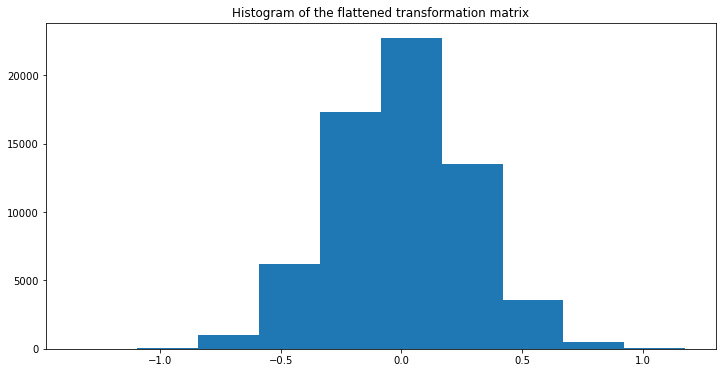

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-17.332043,-10.018864,10.095356,12.740871,-3.621858,1.435229,8.677459,2.229198,5.150060,-14.778093,8.108695,-0.572835,-14.696477
1,-1.214274,-6.713947,-10.026963,15.143148,1.385443,-12.023904,6.037941,-8.967004,3.647978,-21.335723,9.732862,0.299266,-15.196394
2,-5.300827,-10.199131,-4.786038,14.169263,3.078262,-12.826562,6.066373,-8.887626,5.957349,-13.883918,-1.038342,4.839731,-7.851581
3,-12.579714,-8.770980,-1.050312,17.962352,7.322978,-22.386658,-11.665662,4.438202,9.578866,-19.367364,10.445118,13.798773,-21.389786
4,-0.013586,-16.943772,7.235381,11.738645,-6.254382,-15.745371,-10.619764,-4.865944,11.419542,-20.124100,2.828259,10.243093,-4.535998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-5.607331,-21.948814,6.461882,7.444693,0.013130,-5.198897,-8.461769,1.001681,7.118340,-13.157957,-1.406071,6.609123,-17.820003
96,4.618977,-6.312395,6.222677,12.000344,0.206963,-6.278012,-14.088454,16.645968,12.995167,-18.682927,1.929929,12.025557,-21.051350
97,-1.711549,-8.374015,3.653722,7.421742,1.608350,-7.191410,-1.725227,0.757061,10.290587,-9.217666,5.589429,5.530239,-19.298725
98,-16.383942,-23.988256,0.294151,9.359212,-0.402552,-19.896653,-11.405773,10.207069,9.254246,-10.851344,3.890163,-1.495865,-18.911673


In [55]:
run_RP(X_smoke, 13, hist=True)

In [90]:
from sklearn.datasets import load_iris
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import statistics


def run_SVD(X_data, y_data):
    # defining dataset
    X, y = X_data, y_data
     # get a list of models
    def get_models():
        models = dict()
        for i in range(1,12):
            steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression(max_iter=1000))]
            models[str(i)] = Pipeline(steps=steps)
        return models
    # evaluate a give model using cross-validation
    def evaluate_model(model, X, y):
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        return scores
    # get the models to evaluate
    models = get_models()
     # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, statistics.mean(scores), statistics.stdev(scores)))
    # plot model performance for comparison
    plt.boxplot(results, labels=names, showmeans=True)
    plt.xticks(rotation=45)
    plt.title("Truncated SVD")
    plt.xlabel("n components")
    plt.ylabel("Mean classification accuracy")
    plt.show()
    
    return plt

>1 0.715 (0.000)
>2 0.715 (0.000)
>3 0.715 (0.000)
>4 0.715 (0.000)
>5 0.715 (0.000)
>6 0.715 (0.000)
>7 0.715 (0.000)
>8 0.715 (0.000)
>9 0.715 (0.000)
>10 0.715 (0.000)
>11 0.715 (0.000)


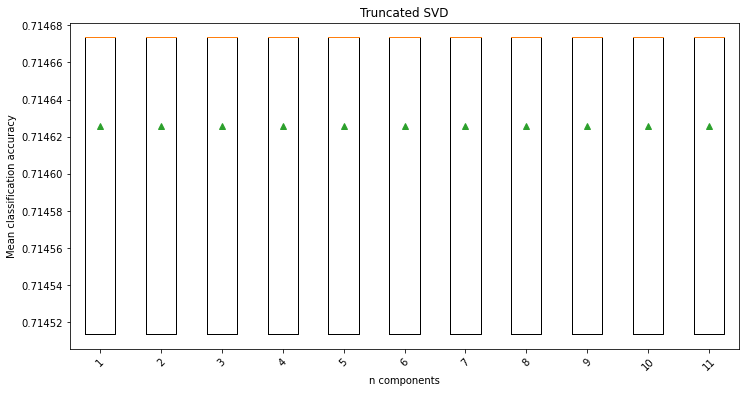

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [92]:
run_SVD(X_smoke, y_smoke)

### Step 3

In [56]:
def evaluate_kmeans(km, X, y):
    start_time = timeit.default_timer()
    km.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    y_mode_vote = cluster_predictions(y,km.labels_)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(km.n_iter_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

In [57]:
from sklearn.decomposition import PCA, FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier as RFC
from itertools import product
from collections import defaultdict
import timeit
import itertools
from collections import Counter

##### Heart

In [58]:
def run_RFC(X,y,df_original):
    rfc = RFC(n_estimators=500,min_samples_leaf=round(len(X)*.01),random_state=5,n_jobs=-1)
    imp = rfc.fit(X,y).feature_importances_
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns[1::])
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.95]
    top_cols = imp.index.tolist()
    return imp, top_cols

imp_heart, topcols_heart = run_RFC(X_heart,y_heart,heart_df)

In [59]:
def cluster_predictions(Y,clusterLabels):
    assert (Y.shape == clusterLabels.shape)
    pred = np.empty_like(Y)
    for label in set(clusterLabels):
        mask = clusterLabels == label
        sub = Y[mask]
        target = Counter(sub).most_common(1)[0][0]
        pred[mask] = target
#    assert max(pred) == max(Y)
#    assert min(pred) == min(Y)    
    return pred

In [60]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [108]:
# imp_phish, topcols_phish = run_RFC(phishX,phishY,df_phish)
pca = PCA(n_components=1,random_state=5).fit_transform(X_heart)
ica = ICA(n_components=2,random_state=5).fit_transform(X_heart)
rpa = GaussianRandomProjection(random_state=5, n_components=5).fit_transform(X_heart)
svd = TruncatedSVD(n_components=9, n_iter=7, random_state=42).fit_transform(X_heart)

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.15
No. Iterations to Converge: 14
F1 Score:  0.73
Accuracy:  0.67     AUC:       0.65
Precision: 0.65     Recall:    0.84
*****************************************************


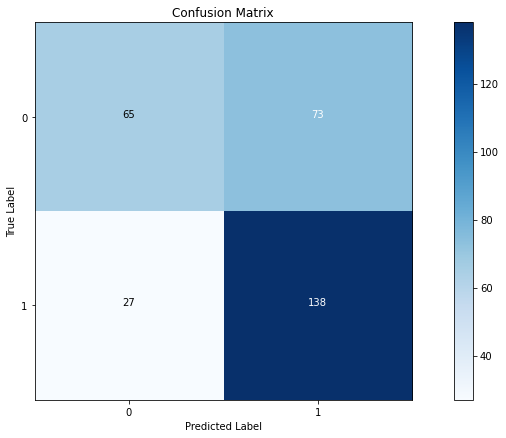

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.13
No. Iterations to Converge: 6
F1 Score:  0.73
Accuracy:  0.70     AUC:       0.69
Precision: 0.71     Recall:    0.75
*****************************************************


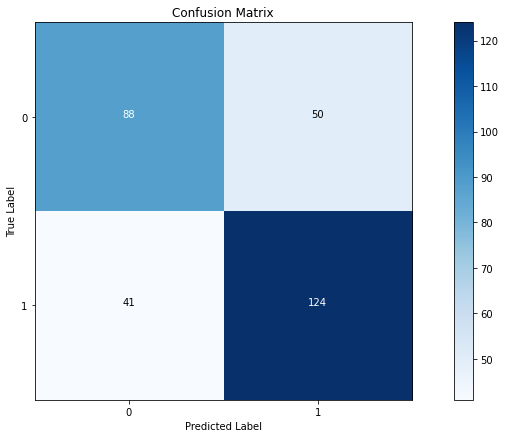

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.11
No. Iterations to Converge: 17
F1 Score:  0.75
Accuracy:  0.72     AUC:       0.71
Precision: 0.72     Recall:    0.78
*****************************************************


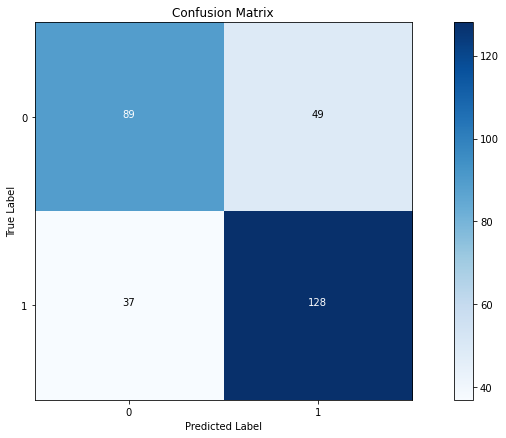

Model Evaluation Metrics Using Mode Cluster Vote
*****************************************************
Model Training Time (s):   0.05
No. Iterations to Converge: 14
F1 Score:  0.73
Accuracy:  0.67     AUC:       0.65
Precision: 0.65     Recall:    0.84
*****************************************************


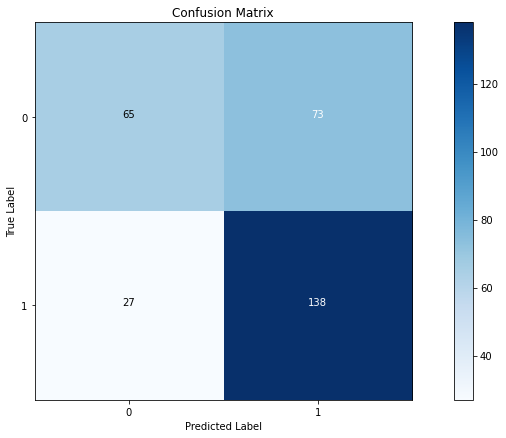

In [106]:
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),pca,y_heart)
evaluate_kmeans(KMeans(n_clusters=12,n_init=10,random_state=100,n_jobs=-1),ica,y_heart)
evaluate_kmeans(KMeans(n_clusters=10,n_init=10,random_state=100,n_jobs=-1),rpa,y_heart)
evaluate_kmeans(KMeans(n_clusters=14,n_init=10,random_state=100,n_jobs=-1),svd,y_heart)

In [112]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
import warnings

def run_kmeans(X,y,title):
    
    warnings.filterwarnings("ignore")

    kclusters = list(np.arange(2,50,2))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []

    for k in kclusters:
        start_time = timeit.default_timer()
        km = KMeans(n_clusters=k, n_init=10,random_state=100,n_jobs=-1).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        sil_scores.append(silhouette_score(X, km.labels_))
        y_mode_vote = cluster_predictions(y,km.labels_)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, km.labels_))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kclusters, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Clusters')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for KMeans: '+ title)
    plt.show()
   
    # # plot homogeneity scores
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(kclusters, homo_scores)
    # plt.grid(True)
    # plt.xlabel('No. Clusters')
    # plt.ylabel('Homogeneity Score')
    # plt.title('Homogeneity Scores KMeans: '+ title)
    # plt.show()

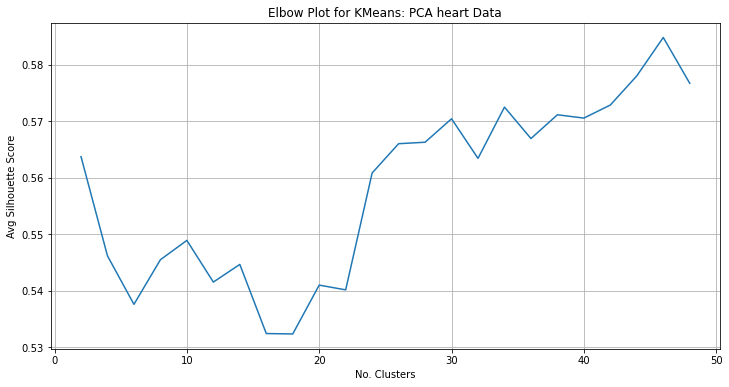

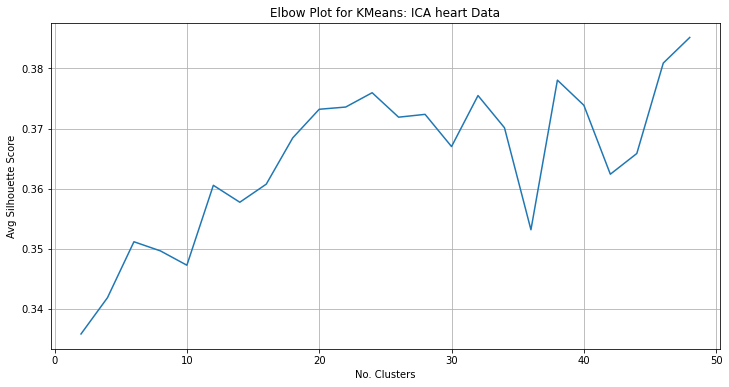

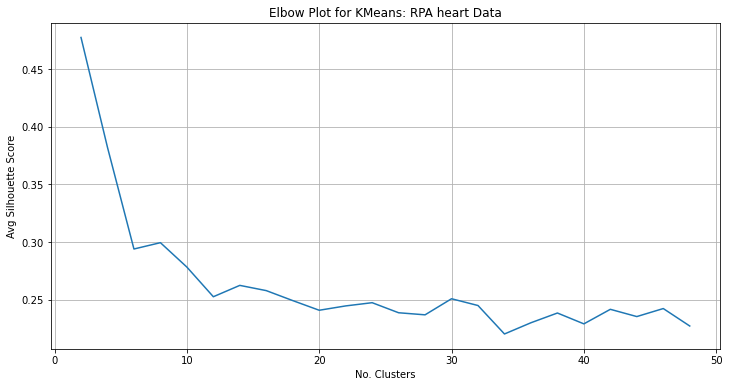

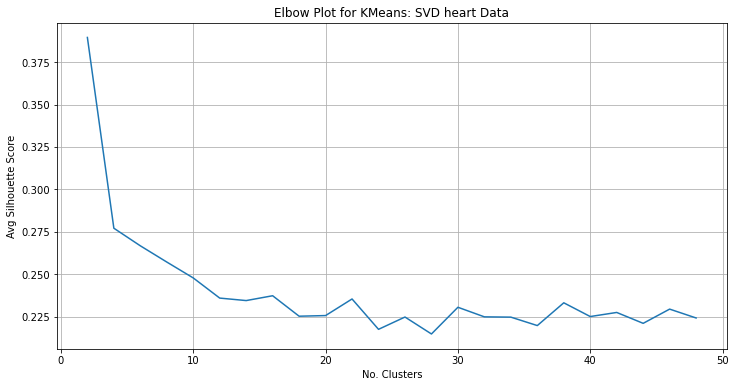

In [113]:
run_kmeans(pca,y_heart,'PCA heart Data')
run_kmeans(ica,y_heart,'ICA heart Data')
run_kmeans(rpa,y_heart,'RPA heart Data')
run_kmeans(svd,y_heart,'SVD heart Data')

In [65]:
from sklearn.mixture import GaussianMixture as EM

def evaluate_EM(em, X, y):
    start_time = timeit.default_timer()
    em.fit(X, y)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    labels = em.predict(X)
    y_mode_vote = cluster_predictions(y,labels)
    auc = roc_auc_score(y, y_mode_vote)
    f1 = f1_score(y, y_mode_vote)
    accuracy = accuracy_score(y, y_mode_vote)
    precision = precision_score(y, y_mode_vote)
    recall = recall_score(y, y_mode_vote)
    cm = confusion_matrix(y, y_mode_vote)

    print("Model Evaluation Metrics Using Mode Cluster Vote")
    print("*****************************************************")
    print("Model Training Time (s):   "+"{:.2f}".format(training_time))
    print("No. Iterations to Converge: {}".format(em.n_iter_))
    print("Log-likelihood Lower Bound: {:.2f}".format(em.lower_bound_))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()

In [114]:
# evaluate_EM(EM(n_components=18,covariance_type='diag',n_init=1,warm_start=True,random_state=100),pca_phish,y_heart)
# evaluate_EM(EM(n_components=28,covariance_type='diag',n_init=1,warm_start=True,random_state=100),ica_phish,y_heart)
# evaluate_EM(EM(n_components=25,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rca_phish,y_heart)
# evaluate_EM(EM(n_components=22,covariance_type='diag',n_init=1,warm_start=True,random_state=100),rfc_phish,y_heart)

In [120]:
def run_EM(X,y,title):

    #kdist =  [2,3,4,5]
    #kdist = list(range(2,51))
    kdist = list(np.arange(2,100,5))
    sil_scores = []; f1_scores = []; homo_scores = []; train_times = []; aic_scores = []; bic_scores = []
    
    for k in kdist:
        start_time = timeit.default_timer()
        em = EM(n_components=k,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X)
        end_time = timeit.default_timer()
        train_times.append(end_time - start_time)
        
        labels = em.predict(X)
        sil_scores.append(silhouette_score(X, labels))
        y_mode_vote = cluster_predictions(y,labels)
        f1_scores.append(f1_score(y, y_mode_vote))
        homo_scores.append(homogeneity_score(y, labels))
        aic_scores.append(em.aic(X))
        bic_scores.append(em.bic(X))
        
    # elbow curve for silhouette score
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(kdist, sil_scores)
    plt.grid(True)
    plt.xlabel('No. Distributions')
    plt.ylabel('Avg Silhouette Score')
    plt.title('Elbow Plot for EM: '+ title)
    plt.show()
   
#     plot homogeneity scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, homo_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('Homogeneity Score')
#     plt.title('Homogeneity Scores EM: '+ title)
#     plt.show()

#     # plot f1 scores
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(kdist, f1_scores)
#     plt.grid(True)
#     plt.xlabel('No. Distributions')
#     plt.ylabel('F1 Score')
#     plt.title('F1 Scores EM: '+ title)
#     plt.show()

    # # plot model AIC and BIC
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(kdist, aic_scores, label='AIC')
    # ax.plot(kdist, bic_scores,label='BIC')
    # plt.grid(True)
    # plt.xlabel('No. Distributions')
    # plt.ylabel('Model Complexity Score')
    # plt.title('EM Model Complexity: '+ title)
    # plt.legend(loc="best")
    # plt.show()

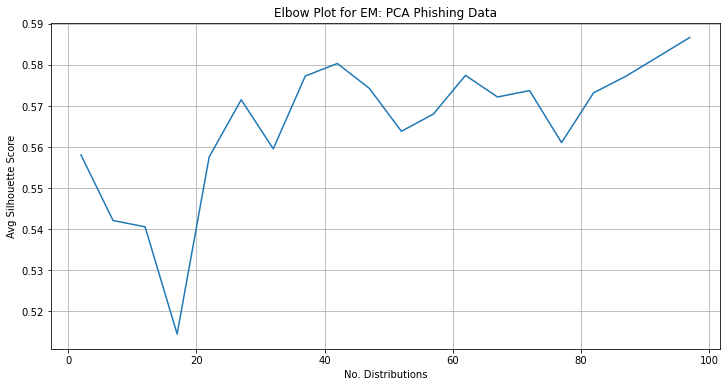

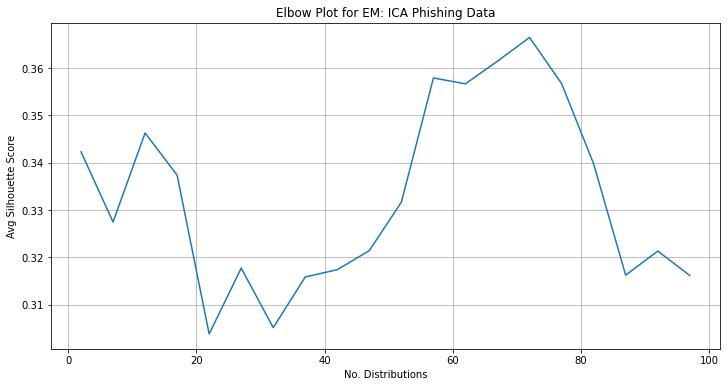

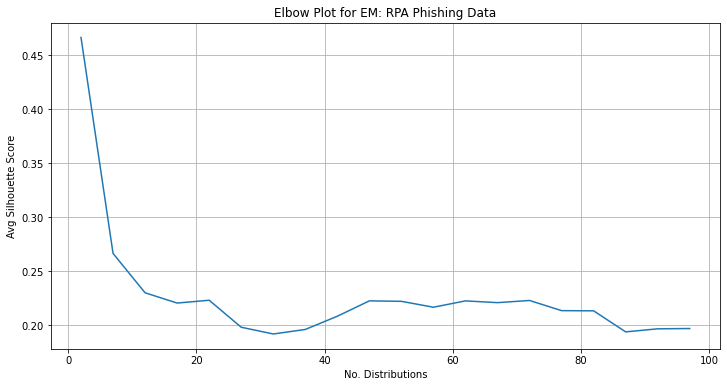

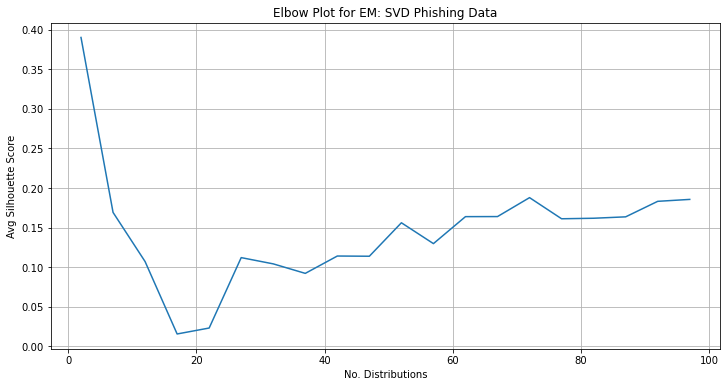

In [121]:
run_EM(pca,y_heart,'PCA Phishing Data')
run_EM(ica,y_heart,'ICA Phishing Data')
run_EM(rpa,y_heart,'RPA Phishing Data')
run_EM(svd,y_heart,'SVD Phishing Data')

In [152]:
pca = PCA(n_components=1,random_state=5).fit_transform(X_smoke)
ica = ICA(n_components=15,random_state=5).fit_transform(X_smoke)
rpa = GaussianRandomProjection(random_state=5, n_components=5).fit_transform(X_smoke)
svd = TruncatedSVD(n_components=6, n_iter=7, random_state=42).fit_transform(X_smoke)

#### Smoke

In [ ]:
run_kmeans(pca,y_smoke,'PCA heart Data')
run_kmeans(ica,y_smoke,'ICA heart Data')
run_kmeans(rpa,y_smoke,'RPA heart Data')
run_kmeans(svd,y_smoke,'SVD heart Data')

In [ ]:
run_EM(pca,y_smoke,'PCA Phishing Data')
run_EM(ica,y_smoke,'ICA Phishing Data')
run_EM(rpa,y_smoke,'RPA Phishing Data')
run_EM(svd,y_smoke,'SVD Phishing Data')

## Step 4

In [69]:
# WAll clock time
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        dt,
        X,
        y,
        scoring="f1",
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

np.linspace(0.01, 1.0, 50)
plt.plot(train_sizes, fit_times_mean, "o-")
plt.fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.1,
)

plt.xlabel("Training examples")
plt.ylabel("fit_times")
plt.title("Wall Clock Time")
plt.show()

NameError: name 'dt' is not defined

In [70]:
def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean

In [137]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, scoring=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

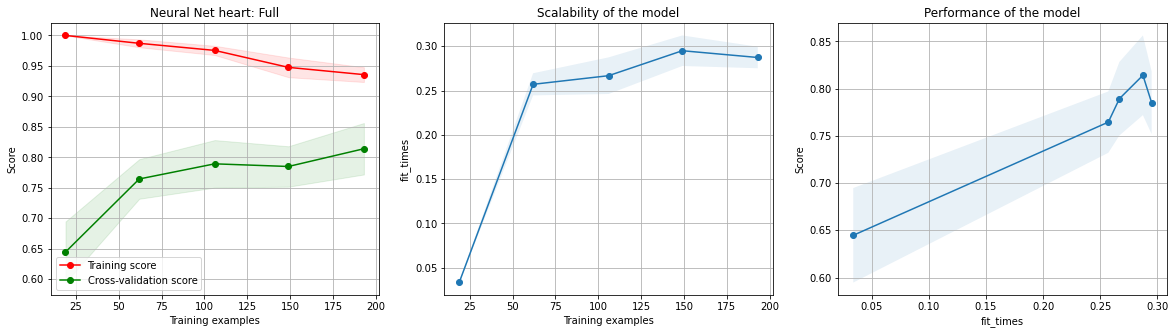

In [138]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV

# Original, full dataset
warnings.filterwarnings("ignore")
X_train, X_test, y_train, y_test = train_test_split(np.array(X_heart),np.array(y_heart), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(full_est, "Neural Net heart: Full", X_train, y_train)
plt.show()

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

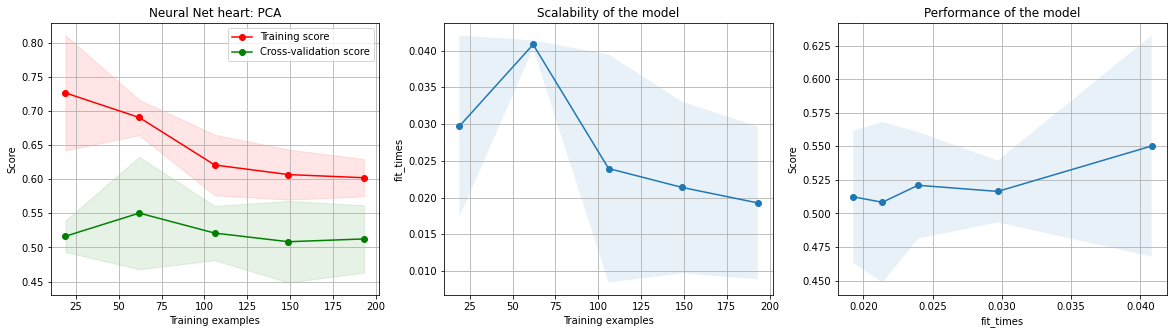

In [139]:
X_train, X_test, y_train, y_test = train_test_split(np.array(pca),np.array(y_heart), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(pca_est, "Neural Net heart: PCA", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

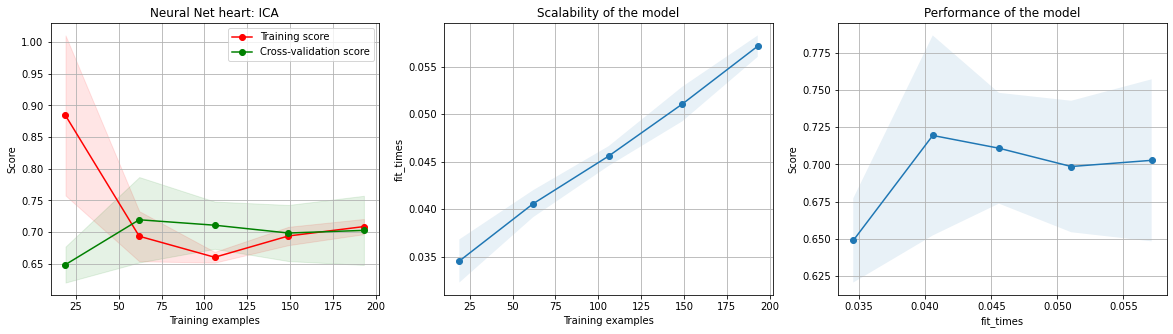

In [140]:
X_train, X_test, y_train, y_test = train_test_split(np.array(ica),np.array(y_heart), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(ica_est, "Neural Net heart: ICA", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

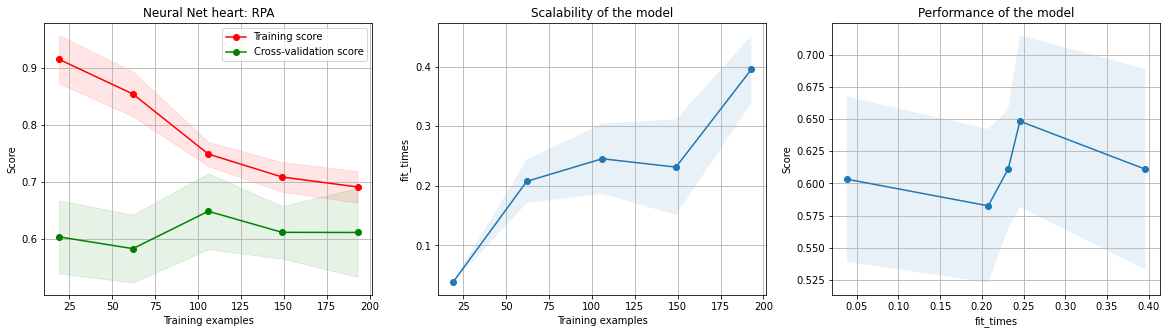

In [141]:
X_train, X_test, y_train, y_test = train_test_split(np.array(rpa),np.array(y_heart), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(rca_est, "Neural Net heart: RPA", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

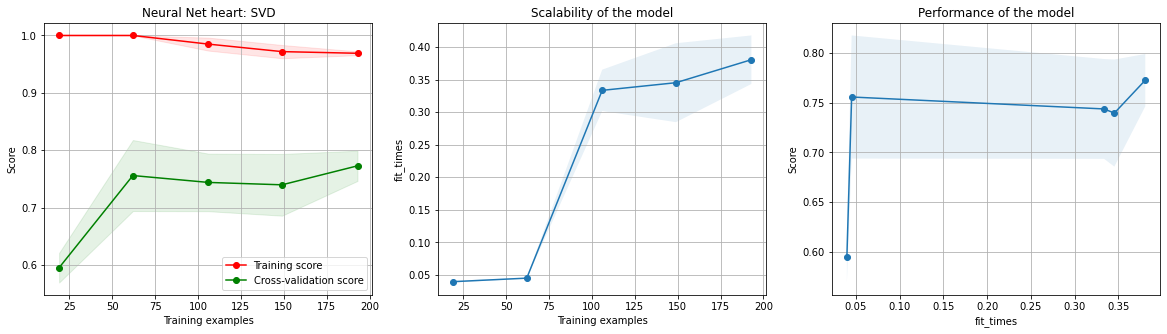

In [142]:
X_train, X_test, y_train, y_test = train_test_split(np.array(svd),np.array(y_heart), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(rfc_est, "Neural Net heart: SVD", X_train, y_train)

## Step 5

In [143]:
def addclusters(X,km_lables,em_lables):
    
    df = pd.DataFrame(X)
    df['KM Cluster'] = km_labels
    df['EM Cluster'] = em_labels
    col_1hot = ['KM Cluster', 'EM Cluster']
    df_1hot = df[col_1hot]
    df_1hot = pd.get_dummies(df_1hot).astype('category')
    df_others = df.drop(col_1hot,axis=1)
    df = pd.concat([df_others,df_1hot],axis=1)
    new_X = np.array(df.values,dtype='int64')
    
    return new_X

In [144]:
km = KMeans(n_clusters=9,n_init=10,random_state=100,n_jobs=-1).fit(X_heart)
km_labels = km.labels_
em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X_heart)
em_labels = em.predict(X_heart)

clust_full = addclusters(X_heart,km_labels,em_labels)
clust_pca = addclusters(pca,km_labels,em_labels)
clust_ica = addclusters(ica,km_labels,em_labels)
clust_rca = addclusters(rpa,km_labels,em_labels)
clust_rfc = addclusters(svd,km_labels,em_labels)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

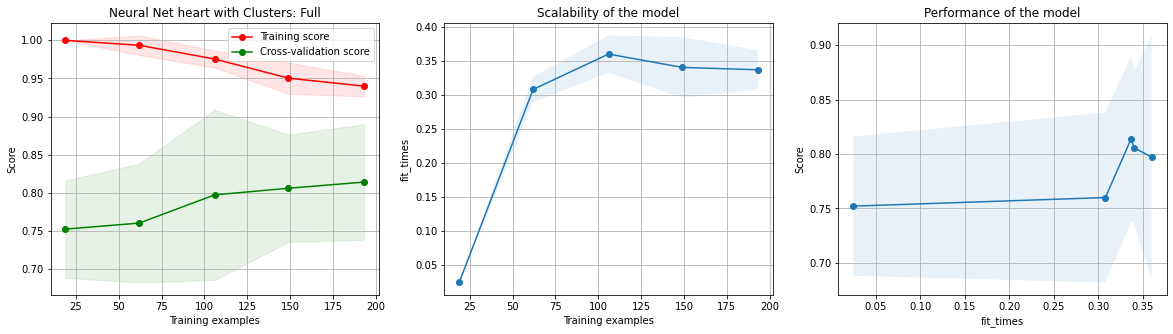

In [145]:
# Original, full dataset
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_full),np.array(y_heart), test_size=0.20)
full_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(full_est, "Neural Net heart with Clusters: Full", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

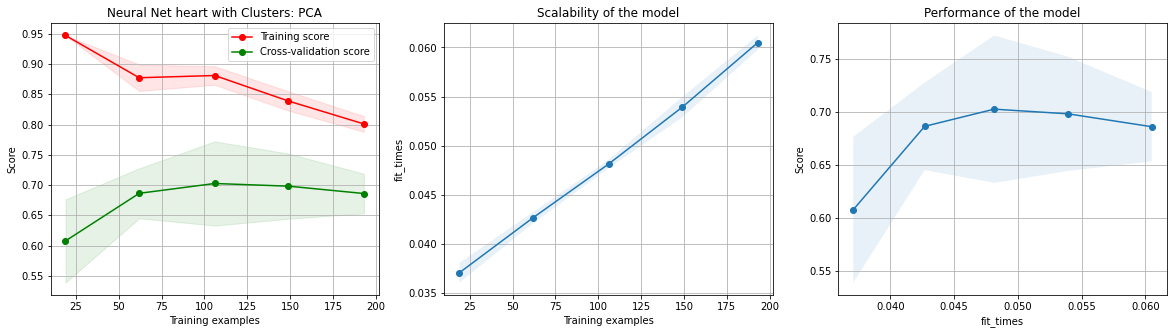

In [146]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_pca),np.array(y_heart), test_size=0.20)
pca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(pca_est, "Neural Net heart with Clusters: PCA", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

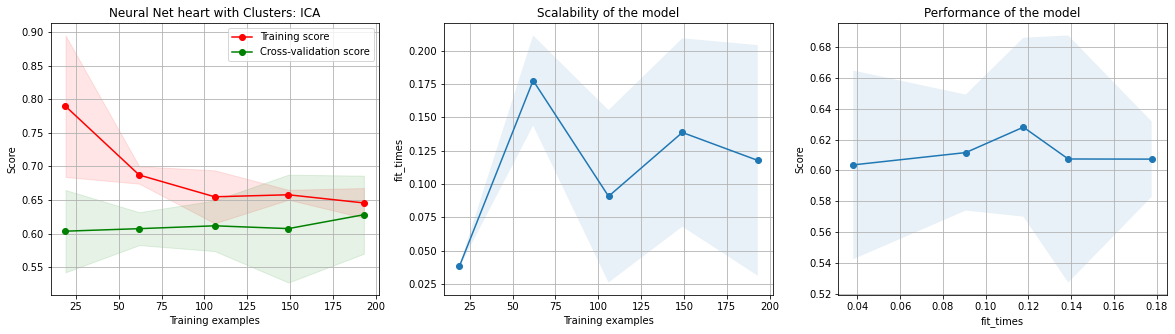

In [147]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_ica),np.array(y_heart), test_size=0.20)
ica_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(ica_est, "Neural Net heart with Clusters: ICA", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

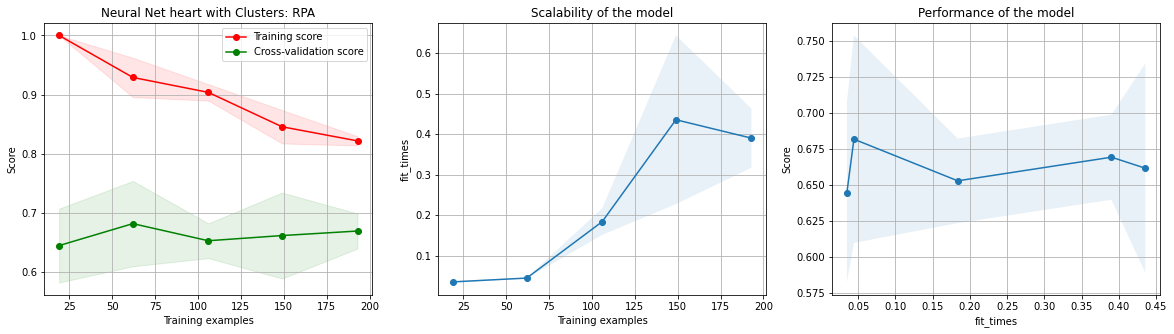

In [148]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rca),np.array(y_heart), test_size=0.20)
rca_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(rca_est, "Neural Net heart with Clusters: RPA", X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/adithyavenkatesh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

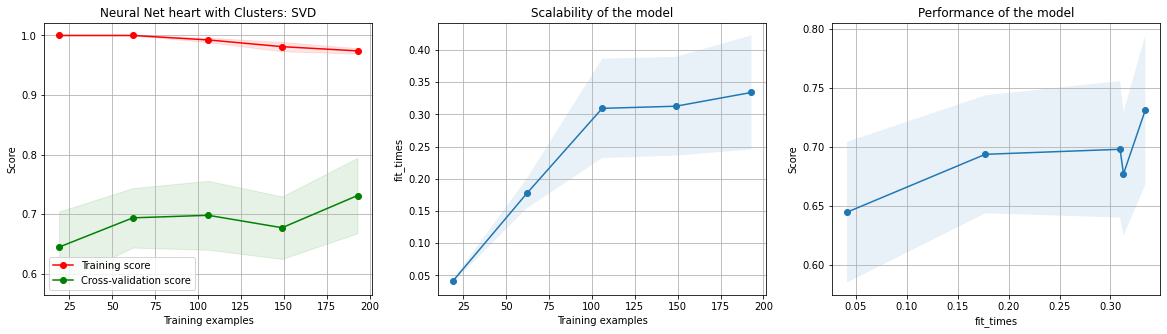

In [149]:
X_train, X_test, y_train, y_test = train_test_split(np.array(clust_rfc),np.array(y_heart), test_size=0.20)
rfc_est = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', activation='logistic', learning_rate_init=0.01, random_state=100)
plot_learning_curve(rfc_est, "Neural Net heart with Clusters: SVD", X_train, y_train)